# Test function on images

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
%matplotlib inline

In [2]:
# Unpickle camera calibration data
with open("./camera_cal/calibration_data.p",'rb') as cal_f:
    calibration_data = pickle.load(cal_f) 
mtx = calibration_data['mtx']
dist = calibration_data['dist']

In [3]:
# Load all images
images = glob.glob("./test_images/*.jpg")

In [4]:
images

['./test_images/test2.jpg',
 './test_images/test1.jpg',
 './test_images/test6.jpg',
 './test_images/test5.jpg',
 './test_images/straight_lines2.jpg',
 './test_images/test3.jpg',
 './test_images/straight_lines1.jpg',
 './test_images/test4.jpg']

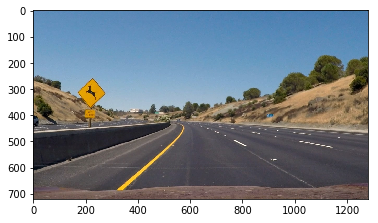

In [5]:
sample_img = mpimg.imread(images[0])
plt.imshow(sample_img)

### 1. Undistort image

In [6]:
def undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

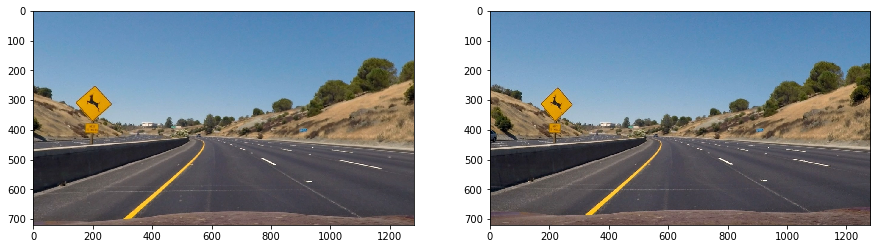

In [8]:
undist_img = undistort(sample_img, mtx, dist)
f, axs = plt.subplots(1,2, figsize=(15,30))
axs[0].imshow(undist_img)
axs[1].imshow(sample_img)
plt.show()

### 2. Color and Gradient Trasformations

In [35]:
def sobel_filter(img, mode='x', low_thresh=0, high_thresh=255, kernel=3):
    
    # Select mode between gradient in x or y, magnitude and direction
    if mode in ['x','y','mag']:
        
        x_flag = int(mode == 'x')
        y_flag = int(mode == 'y')  
        if x_flag or y_flag:
            sobel_out = cv2.Sobel(img, cv2.CV_64F, x_flag, y_flag, ksize=kernel)
            abs_sobel = np.abs(sobel_out)
        else:
            sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=kernel)
            sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=kernel)
            abs_sobel = np.sqrt(sobel_x**2 + sobel_y**2)
        
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        
        # Threshold absolute gradient
        sobel_binary = np.zeros_like(scaled_sobel)
        sobel_binary[(scaled_sobel >= low_thresh) & (scaled_sobel <= high_thresh)] = 1
        
    else:
        print("Sobel param 'mode' must correnspond to one of the following values: 'x','y','mag','dir'")
        sys.exit(-1)
    
    return sobel_binary

In [46]:
def color_filter(img, low_thresh, high_thresh):
    color_binary = np.zeros_like(img)
    color_binary[(img >= low_thresh) & (img <= high_thresh)] = 1
    return color_binary

In [47]:
def color_gradient_transform(img,  sobelparams=None, colorparams=None):
    """
    Perform color and gradient transformations and return binary image according to the given thresholds.
    
    The image can undergo both/either one color transformation and/or one Sobel transformation.
    
    It takes as input an RGB image. Please convert BGR to RGB!
    
    ColorParams:
    - channel: rgb or hls, gray: 'r','g','b', 'h', 'l','s', 'gray'
    - low_threshold: int in range [0, 255], smaller than high_threshold
    - high_threshold: int in range [0, 255], greate than small_threshold
    
    SobelParams:
    - mode: x, y, m, dir
    - channel: rgb or hls 'r','g','b', 'h', 'l','s'
    - low_threshold: int in range [0, 255], smaller than high_threshold
    - high_threshold: int in range [0, 255], greate than small_threshold
    - kernel: kernel size of sobel filter, must be an odd number 
    """
    
    # Compute color transformations only if required by a filter
    img_channel = {}
    channels = set([])
    for params in [colorparams, sobelparams]:
        if params:
            channels = channels.union({params['channel']})
            
    if channels & {'h','l','s'}:
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        img_channel['h'] = hls[:,:,0]
        img_channel['l'] = hls[:,:,1]
        img_channel['s'] = hls[:,:,2]
        
    if channels & {'r','g','b'}:
        img_channel['r'] = img[:,:,0]
        img_channel['g'] = img[:,:,1]
        img_channel['b'] = img[:,:,2]
        
    if 'gray' in channels:
        img_channel['gray'] = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
    # Compute required filters
    if sobelparams:
        sobel_binary = sobel_filter(img_channel[sobelparams['channel']], sobelparams['mode'],
                                   sobelparams['low_thresh'], sobelparams['high_thresh'],
                                   sobelparams['kernel'])
        
    if colorparams:
        color_binary = color_filter(img_channel[colorparams['channel']],
                                   colorparams['low_thresh'], colorparams['high_thresh'])
        
    # Combine filter if both are required
    if colorparams and sobelparams:
        combi_binary = np.zeros_like(img)
        combi_binary[sobel_binary & color_binary] = 1
    elif sobelparams:
        combi_binary = sobel_binary
    elif colorparams:
        combi_binary = color_binary
    else:
        combi_binary = np.copy(img)
    
    return combi_binary

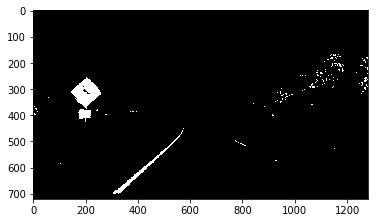

In [54]:
sobelparams = {
    'channel': 'l',
    'mode': 'x',
    'low_thresh': 20,
    'high_thresh': 100,
    'kernel': 5
}

colorparams = {
    'channel': 's',
    'low_thresh': 140,
    'high_thresh': 255
}

cgt_img = color_gradient_transform(undist_img, sobelparams=None, colorparams=colorparams)
plt.imshow(cgt_img, cmap = 'gray')

### 3. Perspective transform 